In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [74]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [75]:
df = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')
pd.set_option('display.max_rows', None)

In [76]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=43)

In [77]:
train.shape, test.shape

((1168, 81), (292, 81))

In [78]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype != 'object']

## CLEANING

In [79]:
high_na_cols = train[cat_cols].columns[train[cat_cols].isna().mean() > 0.8]
train.drop(columns=high_na_cols, inplace=True)
test.drop(columns=high_na_cols, inplace=True)
df_submission.drop(columns=high_na_cols, inplace=True)


# FEATURE ENGINEERING

In [ ]:
train['houseAge'] = train['YrSold'] - train['YearBuilt']
test['houseAge'] = test['YrSold'] - test['YearBuilt']
df_submission['houseAge'] = df_submission['YrSold'] - df_submission['YearBuilt']
train['houseremodelAge'] = train['YrSold'] - train['YearRemodAdd']
test['houseremodelAge'] = test['YrSold'] - test['YearRemodAdd']
df_submission['houseremodelAge'] = df_submission['YrSold'] - df_submission['YearRemodAdd']

In [80]:
train.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd'], inplace=True)
test.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd'], inplace=True)
df_submission.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd'], inplace=True)

<Axes: >

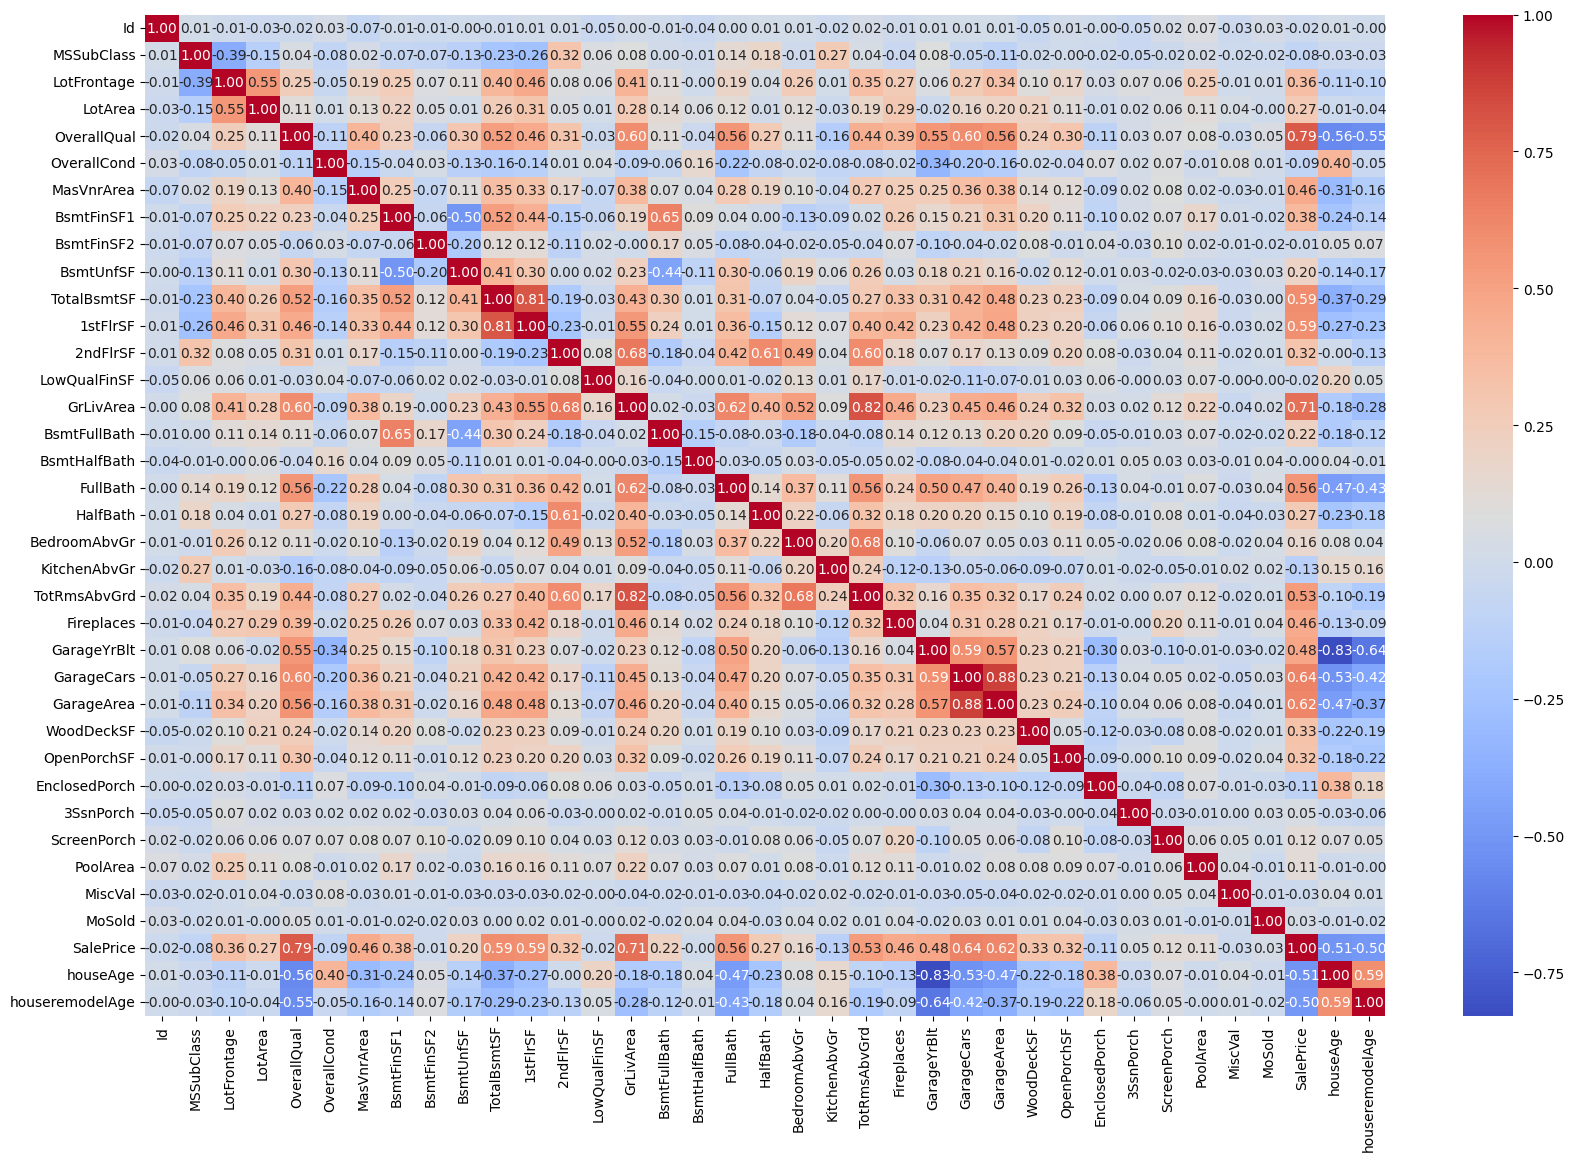

In [81]:
correlation_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(20,13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# FEATURE SELECTION

In [82]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = [col for col in train.columns if train[col].dtype != 'object']

# Create correlation matrix
corr_matrix = train[num_cols].corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Find feature pairs with correlation greater than a threshold
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display highly correlated pairs
if high_corr_pairs:
    print("Highly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print(f"No feature pairs with correlation above {threshold} found.")

# Assuming 'SalePrice' is your target variable (adjust as needed)
target_col = 'SalePrice'  # Change this to your actual target column name

# To remove one feature from each highly correlated pair based on correlation with target
features_to_drop = []
for feat1, feat2, _ in high_corr_pairs:  # Fixed the unpacking syntax
    # Compare correlation with target (assuming target is in the train dataframe)
    if abs(train[feat1].corr(train[target_col])) < abs(train[feat2].corr(train[target_col])):
        features_to_drop.append(feat1)
    else:
        features_to_drop.append(feat2)

# Remove duplicates
features_to_drop = list(set(features_to_drop))
print(f"Features to drop due to high correlation: {features_to_drop}")

Highly correlated feature pairs:
TotalBsmtSF and 1stFlrSF: 0.8065
GrLivArea and TotRmsAbvGrd: 0.8203
GarageYrBlt and houseAge: 0.8288
GarageCars and GarageArea: 0.8784
Features to drop due to high correlation: ['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF']


In [83]:
train.drop(columns=['GarageYrBlt', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF'], inplace=True)
test.drop(columns=['GarageYrBlt', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF'], inplace=True)
df_submission.drop(columns=['GarageYrBlt', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF'], inplace=True)


In [84]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [85]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [86]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [87]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('ohe_pipeline', ohe_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [88]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [89]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [90]:
X_preprocessed = pipeline.fit_transform(X)
df_submission_preproc = pipeline.transform(df_submission)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=43)
X_train.shape,y_train.shape,X_test.shape,y_test.shape, df_submission_preproc.shape

((934, 267), (934,), (234, 267), (234,), (1459, 267))

In [94]:
df_submission_preproc = pd.DataFrame(df_submission_preproc)
df_submission_preproc.to_csv('df-for-test.csv', index=False) 

# TRAINING

In [25]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)


LinearRegression()

In [26]:
y_pred_linear = linear_reg.predict(X_test)

In [27]:
np.sqrt(mean_squared_error(y_test, y_pred_linear))

np.float64(25476.50448722029)

In [28]:
rfr = RandomForestRegressor(random_state=43)

In [29]:
par_grid_rfr = {
    'max_depth' : [2, 4, 16],
    'n_estimators': [100, 200, 300],
    'min_samples_split' : [2, 4, 8]
}

In [30]:
rfr_cv = GridSearchCV(rfr, par_grid_rfr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [31]:
rfr_cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=43), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 16],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [32]:
y_pred_rfr = rfr_cv.predict(X_test)

In [33]:
np.sqrt(-1 * rfr_cv.best_score_)

np.float64(32240.78339239669)

In [34]:
rfr_cv.best_params_

{'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 300}

In [35]:
#same as l2 regularization for linearRegression
ridge = Ridge()

In [36]:
par_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10, 20],
    'solver': ['auto', 'svd', 'lsqr', 'sparse_cg', 'sag']
}

In [37]:
ridge_cv = GridSearchCV(ridge, 
                        par_grid_ridge, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1)

In [38]:
ridge_cv.fit(X_train, y_train)

/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/sklea

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10, 20],
                         'solver': ['auto', 'svd', 'lsqr', 'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

37567.44741404985


{'alpha': 20, 'solver': 'auto'}

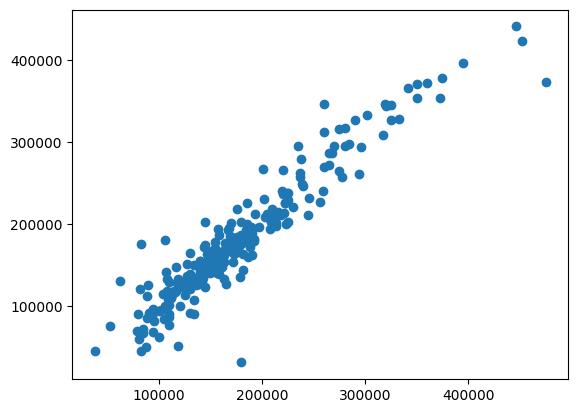

In [39]:
print(np.sqrt(-1 * ridge_cv.best_score_))
y_pred_l2 = ridge_cv.predict(X_test)

plt.scatter(y_test, y_pred_linear)
ridge_cv.best_params_

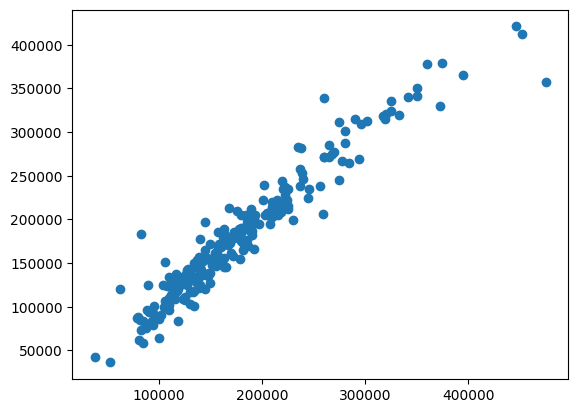

In [40]:
plt.scatter(y_test, y_pred_l2)


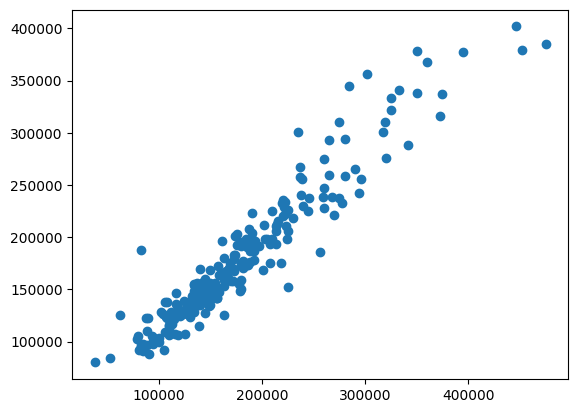

In [41]:
# plt.scatter(y_test, y_pred_l2)
plt.scatter(y_test, y_pred_rfr)

# MLFLOW

In [42]:
import dagshub
import mlflow   
dagshub.init(repo_owner='mr-master-afk', repo_name='ML-House-price-prediction', mlflow=True)

Initialized MLflow to track repo "mr-master-afk/ML-House-price-prediction"

Repository mr-master-afk/ML-House-price-prediction initialized!

In [45]:
def log_scatter_plot(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("True SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(f"{model_name} Predictions vs True")
    plot_path = f"{model_name}_scatter.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()

# # 2. Ridge Regression Run
# with mlflow.start_run(run_name="RidgeRegression"):
#     mlflow.log_param("model", "Ridge")
#     mlflow.log_params(ridge_cv.best_params_)

#     rmse_ridge_cv = np.sqrt(-1 * ridge_cv.best_score_)
#     rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_l2))
#     mlflow.log_metric("CV_RMSE", rmse_ridge_cv)
#     mlflow.log_metric("Test_RMSE", rmse_ridge_test)

#     log_scatter_plot(y_test, y_pred_l2, "RidgeRegression")
#     mlflow.sklearn.log_model(ridge_cv.best_estimator_, "model")

# # 3. Random Forest Regressor Run
# with mlflow.start_run(run_name="RandomForest"):
#     mlflow.log_param("model", "RandomForest")
#     mlflow.log_params(rfr_cv.best_params_)

#     rmse_rfr_cv = np.sqrt(-1 * rfr_cv.best_score_)
#     rmse_rfr_test = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
#     mlflow.log_metric("CV_RMSE", rmse_rfr_cv)
#     mlflow.log_metric("Test_RMSE", rmse_rfr_test)

#     log_scatter_plot(y_test, y_pred_rfr, "RandomForest")
#     mlflow.sklearn.log_model(rfr_cv.best_estimator_, "model")

In [46]:
#best model
model_name = "best_model_house_price"
with mlflow.start_run(run_name="LinearRegression_Final"):
    mlflow.log_param("model", "LinearRegression")
    rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
    mlflow.log_metric("RMSE", rmse_linear)

    log_scatter_plot(y_test, y_pred_linear, "LinearRegression_Final")

    # Log and register the model
    mlflow.sklearn.log_model(
        sk_model=linear_reg,
        artifact_path="model",
        registered_model_name=model_name
    )

    print(f"Linear model logged and registered as '{model_name}'")

2025/04/11 22:32:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'best_model_house_price'.
2025/04/11 22:32:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_house_price, version 1
Created version '1' of model 'best_model_house_price'.


Linear model logged and registered as 'best_model_house_price'
🏃 View run LinearRegression_Final at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0/runs/72c2cb5d0d6a4a92b20258a3119688aa
🧪 View experiment at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0
